In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess
digits = load_digits()
X, y_true = digits.data, digits.target
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scaled)
print(f"✓ Loaded: {X.shape[0]} samples, {X.shape[1]} features")

✓ Loaded: 1797 samples, 64 features


In [3]:
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(8, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', s=15, alpha=0.6)
    plt.colorbar(label='Cluster')
    plt.title(title, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate(X, labels, y_true, name):
    mask = labels >= 0
    return {'Algorithm': name, 'ARI': adjusted_rand_score(y_true, labels),
            'Silhouette': silhouette_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan,
            'Davies-Bouldin': davies_bouldin_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan}

print("✓ Functions ready")

✓ Functions ready


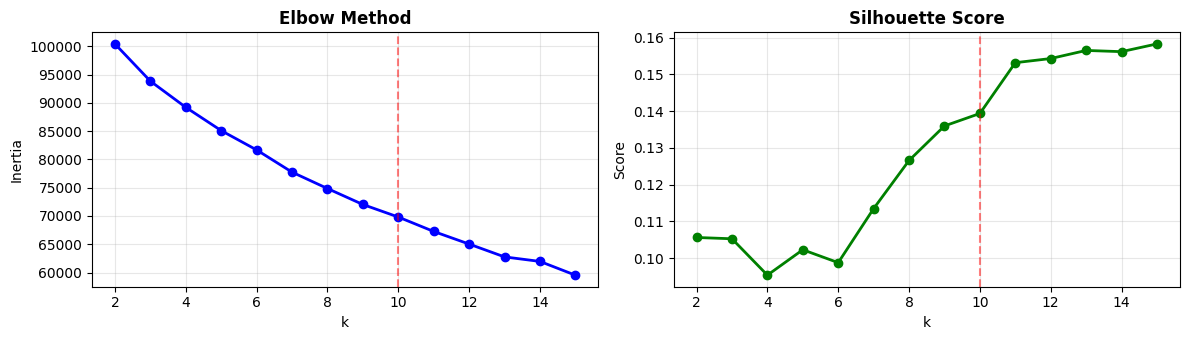

In [4]:
k_range = range(2, 16)
inertias = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled).inertia_ for k in k_range]
silhouettes = [silhouette_score(X_scaled, KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)) for k in k_range]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))
ax1.plot(k_range, inertias, 'bo-', linewidth=2)
ax1.axvline(x=10, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Elbow Method', fontweight='bold')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.grid(alpha=0.3)

ax2.plot(k_range, silhouettes, 'go-', linewidth=2)
ax2.axvline(x=10, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Silhouette Score', fontweight='bold')
ax2.set_xlabel('k')
ax2.set_ylabel('Score')
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

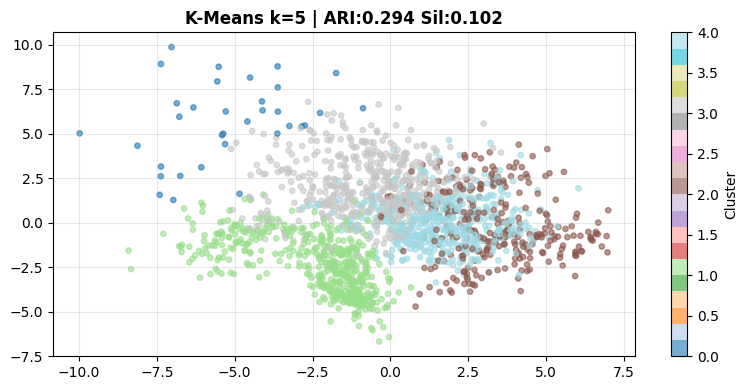

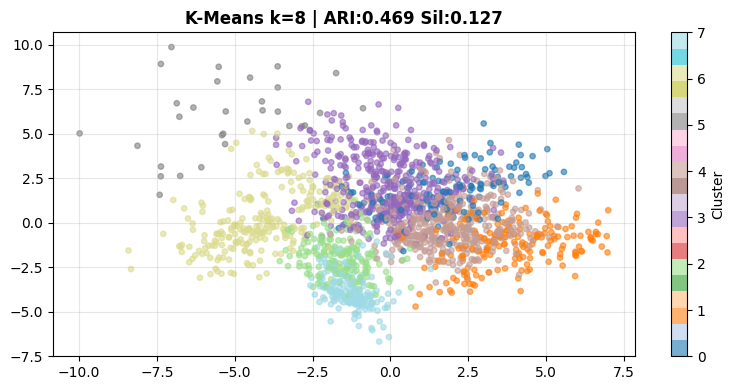

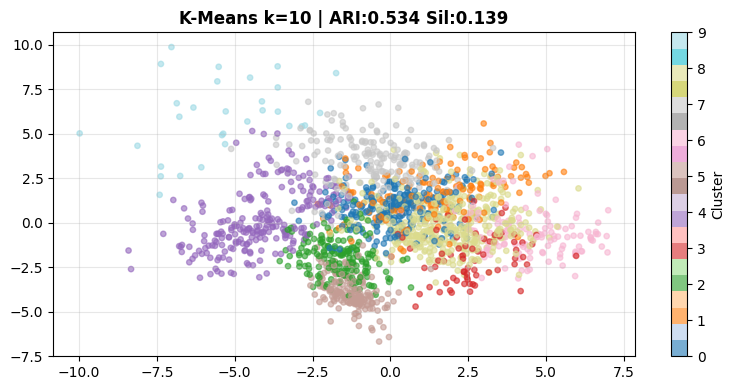

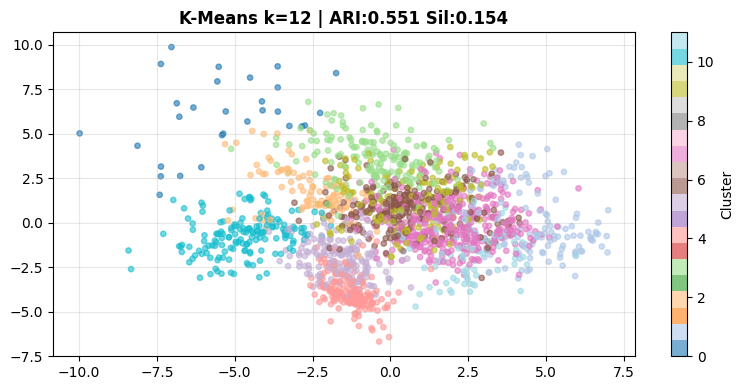

In [5]:
results = []
for k in [5, 8, 10, 12]:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)
    metrics = evaluate(X_scaled, labels, y_true, f'K-Means (k={k})')
    results.append(metrics)
    plot_clusters(X_pca, labels, f'K-Means k={k} | ARI:{metrics["ARI"]:.3f} Sil:{metrics["Silhouette"]:.3f}')


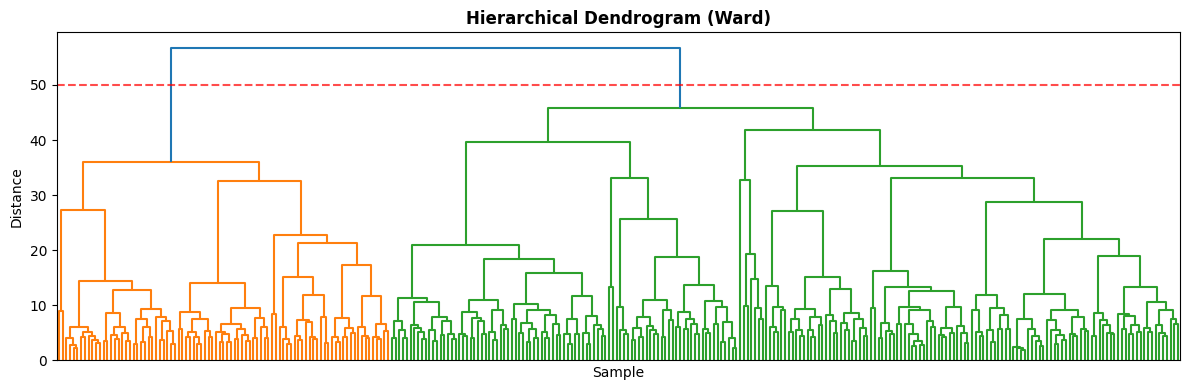

In [6]:
sample_idx = np.random.choice(len(X_scaled), 300, replace=False)
Z = linkage(X_scaled[sample_idx], method='ward')

plt.figure(figsize=(12, 4))
dendrogram(Z, no_labels=True, color_threshold=50)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
plt.title('Hierarchical Dendrogram (Ward)', fontweight='bold')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

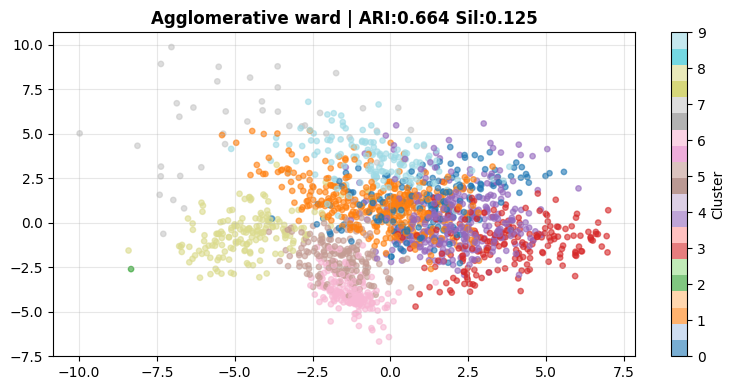

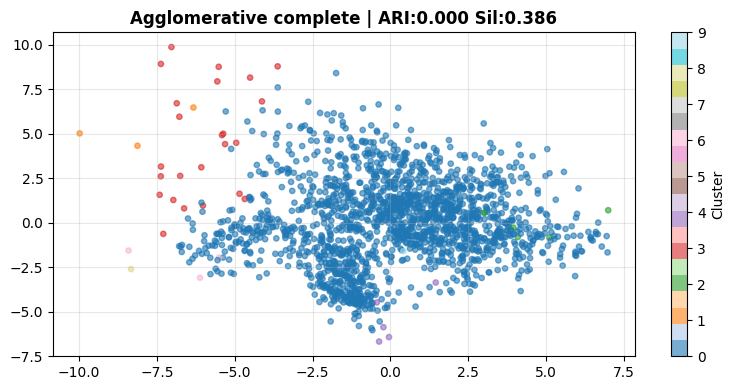

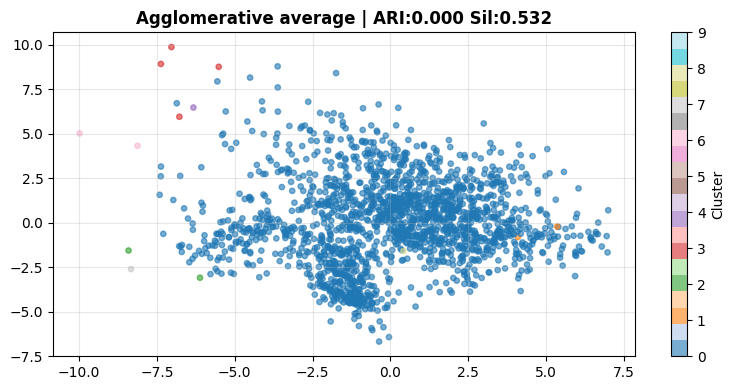

In [7]:
for method in ['ward', 'complete', 'average']:
    labels = AgglomerativeClustering(n_clusters=10, linkage=method).fit_predict(X_scaled)
    metrics = evaluate(X_scaled, labels, y_true, f'Hierarchical ({method})')
    results.append(metrics)
    plot_clusters(X_pca, labels, f'Agglomerative {method} | ARI:{metrics["ARI"]:.3f} Sil:{metrics["Silhouette"]:.3f}')


DBSCAN Tuning:
eps=1.5: 0 clusters, 1797 noise
eps=2.0: 3 clusters, 1778 noise
eps=2.5: 2 clusters, 1756 noise
eps=3.0: 13 clusters, 1618 noise


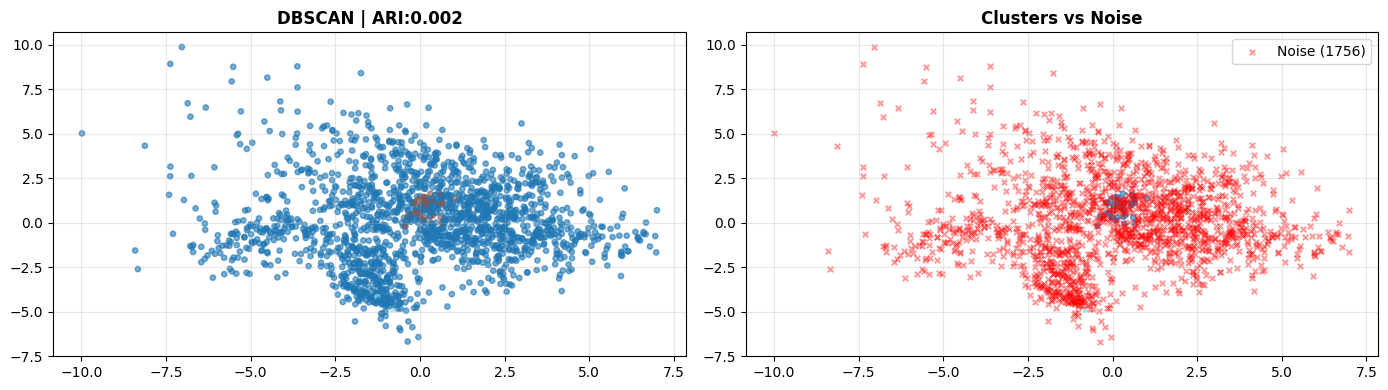

In [8]:
print("DBSCAN Tuning:")
for eps in [1.5, 2.0, 2.5, 3.0]:
    labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps}: {n_clusters} clusters, {list(labels).count(-1)} noise")

# Final DBSCAN
dbscan_labels = DBSCAN(eps=2.5, min_samples=5).fit_predict(X_scaled)
metrics = evaluate(X_scaled, dbscan_labels, y_true, 'DBSCAN')
results.append(metrics)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab20', s=15, alpha=0.6)
ax1.set_title(f'DBSCAN | ARI:{metrics["ARI"]:.3f}', fontweight='bold')
ax1.grid(alpha=0.3)

noise = dbscan_labels == -1
ax2.scatter(X_pca[~noise, 0], X_pca[~noise, 1], c=dbscan_labels[~noise], cmap='tab20', s=15, alpha=0.6)
ax2.scatter(X_pca[noise, 0], X_pca[noise, 1], c='red', s=15, marker='x', alpha=0.4, label=f'Noise ({noise.sum()})')
ax2.set_title('Clusters vs Noise', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame(results)
print("\n📊 PERFORMANCE COMPARISON")
print("="*70)
print(df.to_string(index=False, float_format='%.4f'))
print("="*70)
print(f"\n🏆 Best ARI: {df.loc[df['ARI'].idxmax(), 'Algorithm']} ({df['ARI'].max():.4f})")
print(f"🏆 Best Silhouette: {df.loc[df['Silhouette'].idxmax(), 'Algorithm']} ({df['Silhouette'].max():.4f})")


📊 PERFORMANCE COMPARISON
              Algorithm    ARI  Silhouette  Davies-Bouldin
          K-Means (k=5) 0.2942      0.1023          2.2529
          K-Means (k=8) 0.4687      0.1266          2.0162
         K-Means (k=10) 0.5344      0.1394          1.8770
         K-Means (k=12) 0.5512      0.1543          1.7207
    Hierarchical (ward) 0.6643      0.1253          1.9672
Hierarchical (complete) 0.0003      0.3857          0.6865
 Hierarchical (average) 0.0000      0.5317          0.4405
                 DBSCAN 0.0015      0.6787          0.4220

🏆 Best ARI: Hierarchical (ward) (0.6643)
🏆 Best Silhouette: DBSCAN (0.6787)


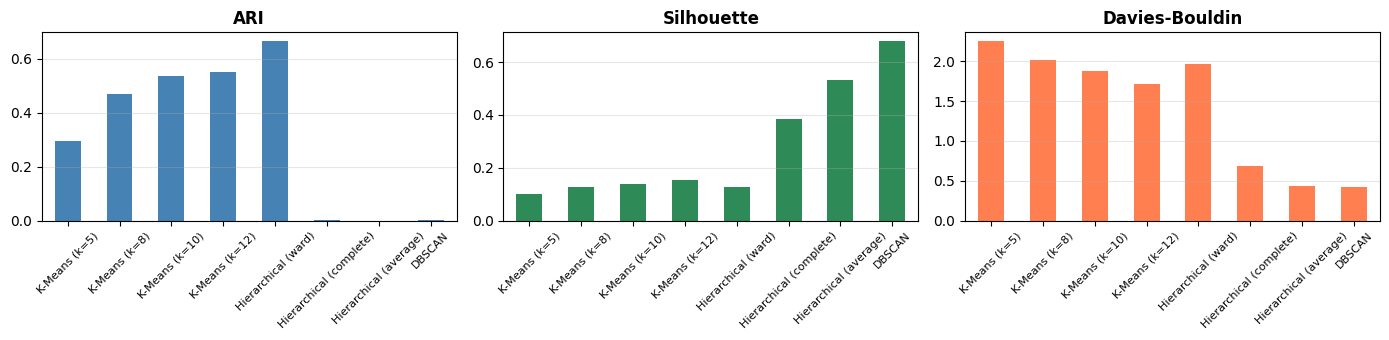

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
for ax, metric, color in zip(axes, ['ARI', 'Silhouette', 'Davies-Bouldin'], ['steelblue', 'seagreen', 'coral']):
    df.plot(x='Algorithm', y=metric, kind='bar', ax=ax, color=color, legend=False)
    ax.set_title(metric, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
print("\n💡 KEY INSIGHTS")
print("="*70)
print("""
• K-Means (k=10): Best ARI, aligns with true classes
• Hierarchical (ward): Strong separation, good for small data
• DBSCAN: Identifies noise, lower ARI due to outliers

WHEN TO USE:
• K-Means → Known k, large data, spherical clusters
• Hierarchical → Unknown k, hierarchical structure
• DBSCAN → Arbitrary shapes, noise detection
""")
print("="*70)

# Comparison table
comp = pd.DataFrame({'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
                     'Complexity': ['O(nki)', 'O(n²log n)', 'O(n log n)'],
                     'Shape': ['Spherical', 'Any', 'Arbitrary'],
                     'Needs k': ['Yes', 'Yes', 'No'],
                     'Finds Noise': ['No', 'No', 'Yes']})
print("\n📋 COMPARISON")
print(comp.to_string(index=False))
print("\n✅ LAB COMPLETE!")


💡 KEY INSIGHTS

• K-Means (k=10): Best ARI, aligns with true classes
• Hierarchical (ward): Strong separation, good for small data
• DBSCAN: Identifies noise, lower ARI due to outliers

WHEN TO USE:
• K-Means → Known k, large data, spherical clusters
• Hierarchical → Unknown k, hierarchical structure
• DBSCAN → Arbitrary shapes, noise detection


📋 COMPARISON
   Algorithm Complexity     Shape Needs k Finds Noise
     K-Means     O(nki) Spherical     Yes          No
Hierarchical O(n²log n)       Any     Yes          No
      DBSCAN O(n log n) Arbitrary      No         Yes

✅ LAB COMPLETE!
